# Intent clasification project

In this notebook I use pre-trained BERT model to perform intent classification on  [“An Evaluation Dataset for Intent Classification and Out-of-Scope Prediction”]( https://github.com/clinc/oos-eval ) dataset. I describe the process for loading, preprocessing and feature transformation on the data. Then, I show how to fine-tune the pre-trained BERT model for this dataset and evaluate it on the test dataset to get close to 97% accuracy. I compare different evaluation metrics and discuss some of the improvements that can be made in future.

## Pre-processing the data

Since the data is in json format, first I load it into a pandas dataframe. 

In [28]:
import pandas as pd
import numpy as np
import json

#load data using Python JSON module
with open('./data_full.json','r') as f:
    data = json.loads(f.read())

df = pd.DataFrame.from_dict(data, orient='index')
df = df.transpose()
df.head()

,oos_val,val,train,oos_test,test,oos_train
0,[set a warning for when my bank account starts...,"[in spanish, meet me tomorrow is said how, tra...",[what expression would i use to say i love you...,"[how much has the dow changed today, oos]","[how would you say fly in italian, translate]","[how much is an overdraft fee for bank, oos]"
1,"[a show on broadway, oos]","[in french, how do i say, see you later, trans...",[can you tell me how to say 'i do not speak mu...,[how many prime numbers are there between 0 an...,"[what's the spanish word for pasta, translate]",[why are exponents preformed before multiplica...
2,"[who has the best record in the nfl, oos]","[how do you say hello in japanese, translate]","[what is the equivalent of, 'life is good' in ...",[can you tell me how to solve simple algebraic...,"[how would they say butter in zambia, translate]","[what size wipers does this car take, oos]"
3,"[how do i find the area of a circle, oos]","[how do i ask about the weather in chinese, tr...","[tell me how to say, 'it is a beautiful mornin...","[can you dim the brightness of my screen, oos]","[how do you say fast in spanish, translate]","[where is the dipstick, oos]"
4,"[how many onions do i have on hand, oos]","[how can i say ""cancel my order"" in french, tr...","[if i were mongolian, how would i say that i a...",[what is the account number to the internet se...,"[what's the word for trees in norway, translate]","[how much is 1 share of aapl, oos]"


From this dataframe we need to select the train, validation and test data and not consider Out-of-Scope intents for this problem. Each cell contains a list with sentence and the intent. e.g. \[how would you say fly in italian, translate\] . I select train, val and test columns from the dataframe and split it into a dataframe containing content and intent using the *slice_df* fuction below. I drop the rows with NaN values.

In [29]:
def col2df(df, column):
    """Split column into a dataframe with content and intent columns."""
    
    # check if there are any NaN values
    print(f'{column} has NaN values: {df[column].isnull().values.any()}')
    # drop the rows with invalid values
    sliced_df = df[column].dropna()
    # split list into content and intent columns
    sliced_df = pd.DataFrame(sliced_df.to_list(),
                             columns=['content', 'intent'])
    return sliced_df

train_df = col2df(df, 'train')
val_df = col2df(df, 'val')
test_df = col2df(df, 'test')

#print(train_df.head())
print(f'instances in train, validation, test datasets: {train_df.shape[0], val_df.shape[0], test_df.shape[0]}')

train has NaN values: False
val has NaN values: True
test has NaN values: True
instances in train, validation, test datasets: (15000, 3000, 4500)


Now I randomly sample 20 intents for classification. I choose the data that corresponds to these randomly sampled intents from train, validation and test datasets. random.sample() samples without replacement, therefore all the intents are different.

In [30]:
def select_rows(df, sampled_intents):
    """Choose data from df that corresponds to labels in sampled_intents."""
    return df.loc[df.intent.isin(sampled_intents)]

import random
random.seed(5)
sampled_intents = random.sample(list(train_df['intent'].unique()), k=20)

# check if sampled intents are unique
if len(sampled_intents) == len(set(sampled_intents)):
   print("sampled intents are unique")

# select rows correspoding to sampled_intents
train_df = select_rows(train_df, sampled_intents)
val_df = select_rows(val_df, sampled_intents)
test_df = select_rows(test_df, sampled_intents)

print(f'instances in train, validation, test datasets after sampling 20 intents:\
      {train_df.shape[0], val_df.shape[0], test_df.shape[0]}')

sampled intents are unique
instances in train, validation, test datasets after sampling 20 intents:      (2000, 400, 600)


## Model Selection

I selected pre-trained BERT with fine-tuning for intent classification on this dataset. As there are only a few instances for training and there were constraints to use less compute time (less that 2 hours), I thought transfer-learning would be the best suitable method as we have pre-trained weights from a large-corpus of data. 

Since transformers are current state-of-the art for language based tasks, I wanted to use a transformer based model. From my research, I figured that BERT was one of the best transformer based models for intent classification task. Therefore, I chose BERT for sequence classification as my model for this task. 

Below I discuss the feature transformation to use with BERT, model, parameters and evaluation. 





In [4]:

%%capture

# install
!pip install transformers pytorch-nlp

# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline



In [5]:
# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)


'GeForce RTX 2080 Ti'

## Feature transformation

To feed the text as input to BERT for sequence classification, it needs to be transformed in 3 steps.

1. Tokenize the input
2. Pad all the sequences to a constant length
3. Add attention mask to the padded input to differentiate from real input.

To tokenize the input we can use the pre-trained BertTokenizer. I use BERT trained on uncased corpus as casing might not be very relevant to intent classification. 

In [6]:
def tokenize(content, tokenizer):
    """Tokenize content using tokenizer."""

    # add special tokens for formatting
    sentences = ["[CLS] " + query + " [SEP]" for query in content]
    # tokenize using BERT tokenizer
    tokenized_texts = [tokenizer.tokenize(sentence) for sentence in sentences]
    return tokenized_texts

In [7]:
# Tokenize with BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Tokenize
train_tokenized_texts = tokenize(train_df.content, tokenizer)
val_tokenized_texts = tokenize(val_df.content, tokenizer)
test_tokenized_texts = tokenize(test_df.content, tokenizer)

print(f'original text of first instance: {train_df.content.iloc[0]}')
print(f'tokenized text of first instance: {train_tokenized_texts[0]}')
      
max_len = max(map(len, train_tokenized_texts))
print(f'maximum length of sequences: {max_len}')

original text of first instance: what is the meaning of realism
tokenized text of first instance: ['[CLS]', 'what', 'is', 'the', 'meaning', 'of', 'realism', '[SEP]']
maximum length of sequences: 26


Maximum length of the sequence is 26. I use 128 as a constant length to pad the sequences.

In [8]:
def pad(tokenized_texts, tokenizer, seq_len):
    """Return mapped and padded input ids."""
    
    # Set the maximum sequence length. 
    MAX_LEN = seq_len
    # Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    # Pad our input tokens
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
    return input_ids

In [9]:
# Map and pad tokenized text
seq_len = 128
train_inputs = pad(train_tokenized_texts, tokenizer, seq_len)
validation_inputs = pad(val_tokenized_texts, tokenizer, seq_len)
test_inputs = pad(test_tokenized_texts, tokenizer, seq_len)

print(f'Mapped and padded input of first instance: {train_inputs[0]}')

Mapped and padded input of first instance: [  101  2054  2003  1996  3574  1997 15650   102     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]


In [10]:
def mask(input_ids):
    "Create attention masks of 1s for each token followed by 0s for padding."
    attention_masks = []
    # Create a mask of 1s for each token followed by 0s for padding
    for seq in input_ids:
      seq_mask = [float(i>0) for i in seq]
      attention_masks.append(seq_mask)
    return attention_masks


In [11]:
# Mask the padded sequences
train_masks = mask(train_inputs)
validation_masks = mask(validation_inputs)
test_masks = mask(test_inputs)

print(f'attention mask of first instance: {train_masks[0]}')

attention mask of first instance: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


I convert the categorical intents into numbers using label encoding from scikit learn.

In [12]:
from sklearn.preprocessing import LabelEncoder

def cat2num(labels):
    """Encode categorical labels to numbers."""
    le = LabelEncoder()
    le.fit(labels)
    label_enc = le.transform(labels)
    return label_enc

train_labels = cat2num(train_df['intent'])
validation_labels = cat2num(np.array(val_df['intent']))
test_labels = cat2num(np.array(test_df['intent']))

print(f'labels before encoding: {sampled_intents}')
print(f'labels after encoding: {np.unique(train_labels)}')

labels before encoding: ['thank_you', 'credit_limit', 'expiration_date', 'travel_alert', 'reset_settings', 'travel_notification', 'replacement_card_duration', 'credit_score', 'rollover_401k', 'pin_change', 'what_is_your_name', 'account_blocked', 'change_ai_name', 'confirm_reservation', 'order', 'definition', 'nutrition_info', 'measurement_conversion', 'ingredient_substitution', 'yes']
labels after encoding: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [13]:
%%capture
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)

validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# Select a batch size for training. 
batch_size = 16

# Create an iterator of our data with torch DataLoader 
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

## Model 
I use the pre-trained uncased BertForSequenceClassification model for this task. It has 12 pre-trained transformer encoder layers and a last classifier layer with randomly initilaized weights. The last layer has 20 outputs for 20 intent classification. 

In [31]:
%%capture
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(sampled_intents))
model.cuda() if torch.cuda.is_available() else model


## BERT fine tuning paraeters

In appendix A.3, authors of the [BERT](https://arxiv.org/pdf/1810.04805.pdf) prescribe following parameters for fine-tuning.

1. Batch size: 16, 32
2. Learning rate (Adam): 5e-5, 3e-5, 2e-5
3. Number of epochs: 2, 3, 4

I use batch size of 16, learning rate of 2e-5 and 4 epochs

In [15]:
# save model in ./model_save/'
import os
def save(model, tokenizer):
    """Save model parameters and tokenizer"""

    output_dir = './model_save/'

    # Create output directory if needed
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    print("Saving model to %s" % output_dir)

    # Save a trained model, configuration and tokenizer using
    # `save_pretrained()`.
    # They can then be reloaded using `from_pretrained()`
    model_to_save = model.module if hasattr(model,
                                                 'module') else model
    model_to_save.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)

In [16]:
# BERT fine-tuning parameters
optimizer = AdamW(model.parameters(),
                     lr=2e-5)

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    """Calculate the accuracy of our predictions vs labels."""
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

epoch 1
Train loss: 2.113362415790558
Validation loss: 0.06581184387207031
Improvement-Detected, save-model
Saving model to ./model_save/
Validation Accuracy: 0.91
epoch 2
Train loss: 0.5918653104305267
Validation loss: 0.014414939880371094
Improvement-Detected, save-model
Saving model to ./model_save/
Validation Accuracy: 0.965
epoch 3
Train loss: 0.1902860153913498
Validation loss: 0.009102639555931092
Improvement-Detected, save-model
Saving model to ./model_save/
Validation Accuracy: 0.975
epoch 4
Train loss: 0.09669880139827729
Validation loss: 0.004042680263519287
Improvement-Detected, save-model
Saving model to ./model_save/
Validation Accuracy: 0.965


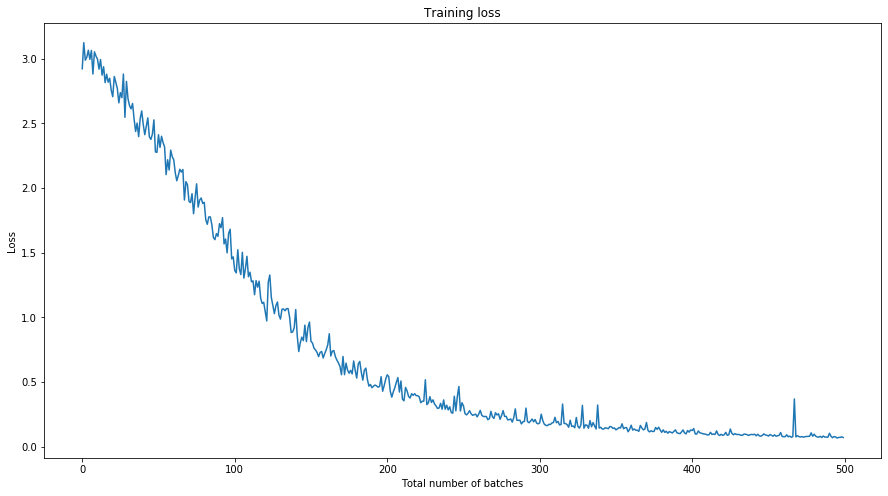

In [17]:
# Store our loss and accuracy for plotting
train_loss_set = []
# Number of training epochs
epochs = 4
min_loss = float('inf')

# BERT training loop
for _ in range(epochs):
    print('epoch {}'.format(_+1))

    ## TRAINING

    # Set our model to training mode
    model.train()
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
        # Forward pass
        output = model(b_input_ids, token_type_ids=None,
                     attention_mask=b_input_mask, labels=b_labels)
        loss = output[0]
        train_loss_set.append(loss.item())
        #print(len(train_loss_set))
        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()
        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
    print("Train loss: {}".format(tr_loss / nb_tr_steps))

    ## VALIDATION

    # Put model in evaluation mode
    model.eval()
    # Tracking variables
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    # Evaluate data for one epoch
    batch_loss = 0
    for batch in validation_dataloader:
        batch_loss = 0
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions                            
            output = model(b_input_ids, token_type_ids=None,
                         attention_mask=b_input_mask, labels=b_labels)
            loss = output[0]
            logits = output[1]

        batch_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1
        
    print(
        "Validation loss: {}".format(batch_loss / nb_eval_steps))
    if batch_loss < min_loss:
        
        print('Improvement-Detected, save-model')
        save(model, tokenizer)
        min_loss = batch_loss

    print(
        "Validation Accuracy: {}".format(eval_accuracy / nb_eval_steps))
    print("==================================================")
    
# plot training performance
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Total number of batches")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

As we can see, the loss seems to converge with in 4 epochs.

## Evaluation

I evaluate the trained BERT model on test data and report accuracy, confusion matrix, precision, recall and f1-score.

In [32]:
%%capture
# loading the model
del model  # to show loading works

# load the fine-tuned saved model and vocabulary 
output_dir = './model_save/'
model = BertForSequenceClassification.from_pretrained(output_dir)
tokenizer = BertTokenizer.from_pretrained(output_dir)

# Copy the model to GPU if it exists
model.to(device)

In [24]:
# convert to tensor
prediction_inputs = torch.tensor(test_inputs)
prediction_masks = torch.tensor(test_masks)
prediction_labels = torch.tensor(test_labels)

# Create an iterator of our data with torch DataLoader 
batch_size = 32  
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

# Put model in evaluation mode
model.eval()
# Tracking variables
predictions, true_labels = [], []
# Predict
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory
    # and speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        output = model(b_input_ids, token_type_ids=None,
                       attention_mask=b_input_mask)
        logits = output[0]
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

# Flatten the predictions and true values for aggregate  evaluation
# on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]


In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

def plot_confusion_matrix(flat_true_labels, flat_predictions, intents):
    cm = confusion_matrix(flat_true_labels,
                          flat_predictions)
    array = cm
    df_cm = pd.DataFrame(array, index=[i for i in intents],
                         columns=[i for i in intents])
    plt.figure(figsize=(10, 7))
    sn.heatmap(df_cm, annot=True)


Classification accuracy using BERT Fine Tuning: 97.17%


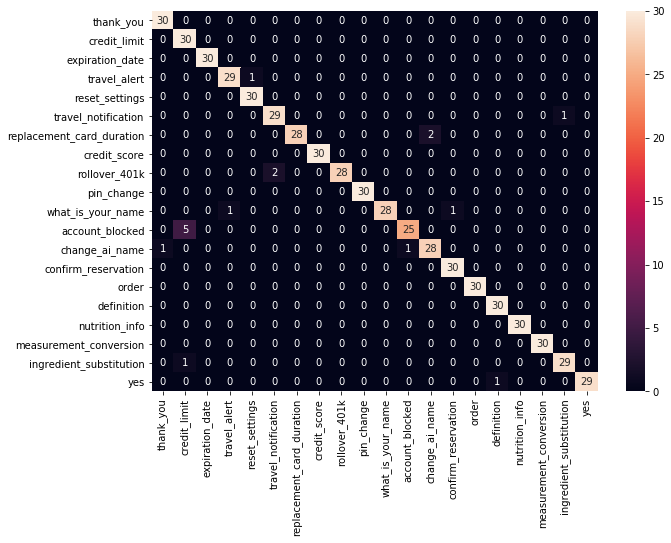

In [26]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder

# calculate accuracy
accuracy = np.sum(flat_predictions == flat_true_labels) / len(
    flat_true_labels)
print('Classification accuracy using BERT Fine Tuning: {0:0.2%}'.format(
    accuracy))

plot_confusion_matrix(flat_true_labels, flat_predictions, sampled_intents)


x-axis shows the predicted labels and y-axis shows the true lables in the above confusion matrix

In [27]:
from sklearn.metrics import classification_report

target_names = sampled_intents
print(classification_report(flat_true_labels, flat_predictions, target_names=target_names))

                           precision    recall  f1-score   support

                thank_you       0.97      1.00      0.98        30
             credit_limit       0.83      1.00      0.91        30
          expiration_date       1.00      1.00      1.00        30
             travel_alert       0.97      0.97      0.97        30
           reset_settings       0.97      1.00      0.98        30
      travel_notification       0.94      0.97      0.95        30
replacement_card_duration       1.00      0.93      0.97        30
             credit_score       1.00      1.00      1.00        30
            rollover_401k       1.00      0.93      0.97        30
               pin_change       1.00      1.00      1.00        30
        what_is_your_name       1.00      0.93      0.97        30
          account_blocked       0.96      0.83      0.89        30
           change_ai_name       0.93      0.93      0.93        30
      confirm_reservation       0.97      1.00      0.98     

## Future work

As we can see that precision for credit limit is lowest with a score of 0.83. We can observe from confusion matrix that 5 instances of account blocked are getting misclassified as credit limit. This could be expected as credit limit and account blocked both deal with bank accounts and may have similar tags.

I would like to check if there are any specific tags that are present both in credit limit and account blocked that is throwing the model off. 

I could also probably tokenize intents using BERT tokenizer or a different tokenizer. This would make the intents ordinal as closer intents may have closer ids. It would be interesting to see how that would impact the classification.

I would also like to use one hot encoding for the classes instead of numbers to see if that has any impact on this classification.

